In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

import gym
from acrobot import AcrobotEnv

In [2]:
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

In [3]:
import warnings 
warnings.filterwarnings('ignore')

## Explore The Environment

In [5]:
env = AcrobotEnv(); env.seed(90);

Environment Display:
State space Box(6,)
Action space Discrete(3)
Final score: -200.0


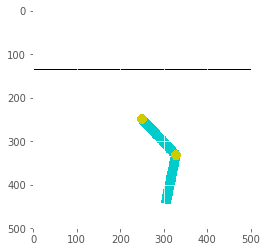

In [6]:
print('Environment Display:')

state = env.reset() # reset environment to a new, random state
score = 0

num_episodes = 200 # limit of moves in this environment
for time_step in range(num_episodes):
    
    action = env.action_space.sample()
    env.render()
    next_state, reward, done, _ = env.step(action) # a -1 reward is applied for each move taken (including doing nothing)
    score += reward
    
    state = next_state
    if done:
        break

print('State space', env.observation_space)
print('Action space', env.action_space)
print('Final score:', score)
plt.imshow(env.render(mode='rgb_array'))
plt.show()

env.close()

In [7]:
# explore state (observation) space
space_low = env.observation_space.low
space_high = env.observation_space.high
print("State space:", env.observation_space)
print(f"- low: {space_low[0]}, {space_low[1]}, {space_low[2]}, {space_low[3]}, {space_low[4]}, {space_low[5]}")
print(f"- high: {space_high[0]}, {space_high[1]}, {space_high[2]}, {space_high[3]}, {space_high[4]}, {space_high[5]},", )

State space: Box(6,)
- low: -1.0, -1.0, -1.0, -1.0, -12.566370964050293, -28.274333953857422
- high: 1.0, 1.0, 1.0, 1.0, 12.566370964050293, 28.274333953857422,


In [8]:
# explore the action space
print("Action space:", env.action_space)

Action space: Discrete(3)


## Discretize the State Space with a Tiling Grid

In [35]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space."""
    
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    return grid

In [36]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications."""
    
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]

In [49]:
def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    
    return ax

In [50]:
low = [-1.0, -5.0]
high = [1.0, 5.0]

In [51]:
tiling_specs = [((10, 10), (-0.066, -0.33)), ((10, 10), (0.0, 0.0)),((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs) # tiling specs: [(bins, offsets)]

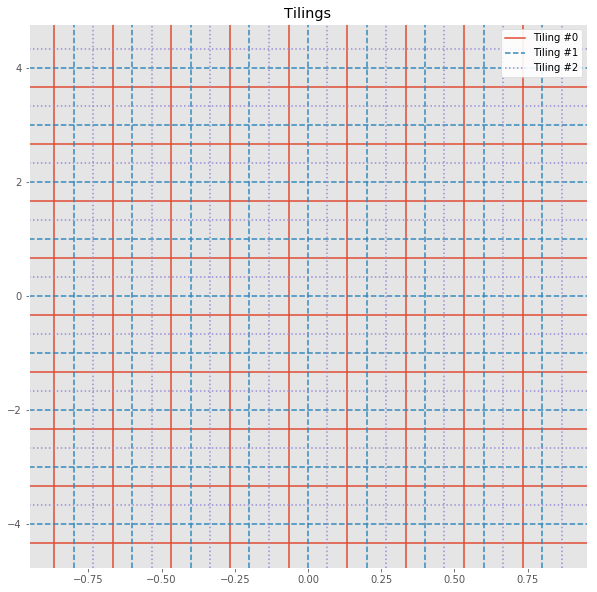

In [52]:
ax = visualize_tilings(tilings)

In [53]:
def discretize(sample, grid):
    """Discretize a sample as per given grid."""
    
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))

In [54]:
def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding."""
    
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample

In [55]:
samples = [(-1.2 , -5.1 ), (-0.75,  3.25), (-0.5 ,  0.0 ), ( 0.25, -1.9 ),
           ( 0.15, -1.75), ( 0.75,  2.5 ), ( 0.7 , -3.7 ), ( 1.0 ,  5.0 )]

encoded_samples = [tile_encode(sample, tilings) for sample in samples]

In [56]:
def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    
    samples = np.array(samples)
    
    # show tiling grids
    ax = visualize_tilings(tilings)
    
    # if bounds (low, high) are specifid, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]
    
    # map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # in case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # so plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
                
    # finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')
    ax.margins(x=0, y=0) # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    
    plt.show()
    
    return ax

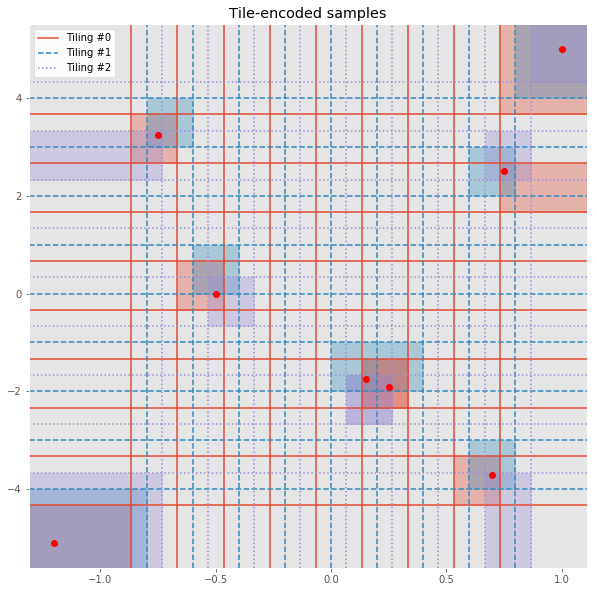

In [57]:
ax = visualize_encoded_samples(samples, encoded_samples, tilings)

## Visualize The Discritization

---